<b>Цель работы: </b> построение и применение моделей машинного обучения к несбалансированным данным.

In [3]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
# Загружаем датасет и выводим его как таблицу

dataset_path = 'lending_data.csv'
df = pd.read_csv(dataset_path)

# Выводим данные в виде таблицы
display(df)

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.00,7.67,52800,0.43,5,1,22800,0
1,8400.00,6.69,43600,0.31,3,0,13600,0
2,9000.00,6.96,46100,0.35,3,0,16100,0
3,10700.00,7.66,52700,0.43,5,1,22700,0
4,10800.00,7.70,53000,0.43,5,1,23000,0
...,...,...,...,...,...,...,...,...
77531,19100.00,11.26,86600,0.65,12,2,56600,1
77532,17700.00,10.66,80900,0.63,11,2,50900,1
77533,17600.00,10.60,80300,0.63,11,2,50300,1
77534,16300.00,10.07,75300,0.60,10,2,45300,1


# Построение модели линейной регрессии для предсказания дохода заемщика

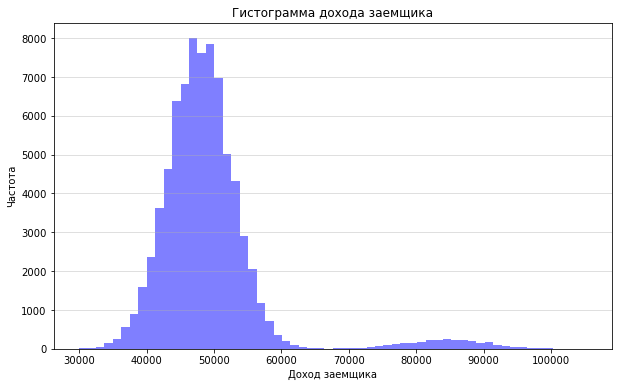

In [6]:
# Постройте гистограмму дохода заемщика (borrower_income)

plt.figure(figsize=(10, 6))
plt.hist(df['borrower_income'], bins=60, color='blue', alpha=0.5)
plt.title('Гистограмма дохода заемщика')
plt.xlabel('Доход заемщика')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.5)
plt.show()

In [7]:
# Применим лог трансформ к таргетной переменной
df['borrower_income'] = np.log(df['borrower_income'])

y = df['borrower_income'].values
y

array([10.87426647, 10.68281243, 10.73856823, ..., 11.2935249 ,
       11.22923541, 11.18857941])

### Нормализация данных

In [9]:
# 1. Удалите ненужные колонки ('borrower_income', 'debt_to_income', 'loan_status')

drop_columns = ['borrower_income', 'debt_to_income', 'loan_status']
df_cleaned = df.drop(columns=drop_columns)
df_cleaned

,loan_size,interest_rate,num_of_accounts,derogatory_marks,total_debt
0,10700.00,7.67,5,1,22800
1,8400.00,6.69,3,0,13600
2,9000.00,6.96,3,0,16100
3,10700.00,7.66,5,1,22700
4,10800.00,7.70,5,1,23000
...,...,...,...,...,...
77531,19100.00,11.26,12,2,56600
77532,17700.00,10.66,11,2,50900
77533,17600.00,10.60,11,2,50300
77534,16300.00,10.07,10,2,45300


In [10]:
# 2. Используйте StandardScaler из библиотеки sklearn для нормализации численных данных
from sklearn.preprocessing import StandardScaler

numerical_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Инициализация StandardScaler
scaler = StandardScaler()

In [11]:
# Не забудьте обозначить нормализованные признаки за Х

X = scaler.fit_transform(df_cleaned[numerical_columns])
X_df = pd.DataFrame(X, columns=numerical_columns)

### Деление данных на тренировочные и тестовые выборки

In [13]:
# Используйте train_test_split для деления данных на выборки
from sklearn.model_selection import train_test_split

Y_df = df['borrower_income']

X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.25, random_state=12345)

### Построение модели

In [15]:
# Инициализируйте модель линейной регрессии и примерьте тренировочные данные
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [16]:
y_train_pred = model.predict(X_train)

### Оценка модели (замените переменные, если нужно)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

print("R-squared score:", r2_score(y_train, y_train_pred))
print("MSE:", mean_squared_error(y_train, y_train_pred))

R-squared score: 0.9759816905505527
MSE: 0.000508229932885199


In [19]:
y_train

50055   10.90
68852   10.66
4284    10.81
27641   10.78
44572   10.96
         ... 
16930   10.62
28005   10.64
4094    10.70
2177    10.70
77285   11.37
Name: borrower_income, Length: 58152, dtype: float64

In [20]:
y_train_pred = np.exp(y_train_pred)

df1 = pd.DataFrame(data = y_train, columns = ['y_true'])
df2 = pd.DataFrame(data = y_train_pred, columns = ['prediction'])

train_pred = pd.concat([df1, df2],  axis=1)

display(train_pred)

,y_true,prediction
0,NaN,53158.43
1,NaN,43379.25
2,NaN,48797.04
3,NaN,47392.93
4,NaN,56142.20
...,...,...
58147,NaN,42290.41
58148,NaN,42912.30
58149,NaN,44810.25
58150,NaN,44747.85


### Предсказания на тестовой выборке

In [22]:
y_test_pred = model.predict(X_test)

In [23]:
print("R-squared score:", r2_score(y_test, y_test_pred))
print("MSE:", mean_squared_error(y_test, y_test_pred))

R-squared score: 0.9766427095554321
MSE: 0.0004980704995363948


In [24]:
y_test_pred = np.exp(y_test_pred)

In [25]:
df1 = pd.DataFrame(data = y_test, columns = ['y_true'])
df2 = pd.DataFrame(data = y_test_pred, columns = ['prediction'])

test_pred = pd.concat([df1, df2],  axis=1)

display(test_pred)

,y_true,prediction
0,NaN,56249.17
1,NaN,48946.48
2,NaN,52667.94
3,NaN,83968.03
4,NaN,43947.18
...,...,...
19379,NaN,46535.57
19380,NaN,47231.19
19381,NaN,51985.33
19382,NaN,44947.48


In [26]:
test_pred.describe()

,prediction
count,19384.00
mean,49234.78
std,8953.31
min,35911.44
25%,45028.11
50%,47532.78
75%,50803.58
max,126116.61


# Построение модели логистической регрессии для предсказания "loan_status" (возможности заемщика выплатить кредит)

In [28]:
display(df)

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.00,7.67,10.87,0.43,5,1,22800,0
1,8400.00,6.69,10.68,0.31,3,0,13600,0
2,9000.00,6.96,10.74,0.35,3,0,16100,0
3,10700.00,7.66,10.87,0.43,5,1,22700,0
4,10800.00,7.70,10.88,0.43,5,1,23000,0
...,...,...,...,...,...,...,...,...
77531,19100.00,11.26,11.37,0.65,12,2,56600,1
77532,17700.00,10.66,11.30,0.63,11,2,50900,1
77533,17600.00,10.60,11.29,0.63,11,2,50300,1
77534,16300.00,10.07,11.23,0.60,10,2,45300,1


In [29]:
# Делим данные на признаки и таргет

# отделяем переменную 'loan_status' как таргет
y = df['loan_status'] 

# остальные переменные оставляем как признаки 
X = df.drop('loan_status', axis=1)

In [30]:
# проверяем сбалансированность классов
y.value_counts()

0    75036
1     2500
Name: loan_status, dtype: int64

### Деление данных на тренировочную и тестовую выборки

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Построение модели

In [34]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Инициируйте модель логистической регрессии

model_lr = LogisticRegression(random_state=1)

model_lr.fit(X_train, y_train)

LogisticRegression(random_state=1)

### Предсказания для тестовых данных

In [36]:
test_pred_model_lr = model_lr.predict(X_test)
test_pred_model_lr

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Оценка работы модели (на несбалансированных данных)

In [38]:
# Print the balanced_accuracy score of the model
balanced_accuracy_score(y_test, test_pred_model_lr)

0.9584300249622596

Матрица ошибок:
 [[18660   105]
 [   48   571]]


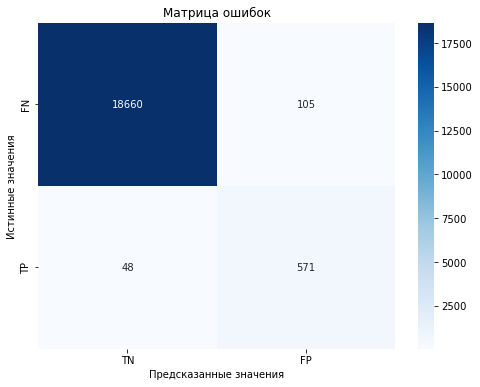

In [39]:
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix for the model
conf_matrix_nobalanced = confusion_matrix(y_test, test_pred_model_lr)
print("Матрица ошибок:\n", conf_matrix_nobalanced)

# TN FP
# FN TP

# Визуализируем матрицу ошибок на несбалансированных данных
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nobalanced, annot=True, fmt='d', cmap='Blues', xticklabels=['TN', 'FP'], yticklabels=['FN', 'TP'])
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок')
plt.show()

In [40]:
# Print the classification report for the model
print(classification_report_imbalanced(y_test, test_pred_model_lr))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.92      1.00      0.96      0.92     18765
          1       0.84      0.92      0.99      0.88      0.96      0.91       619

avg / total       0.99      0.99      0.92      0.99      0.96      0.92     19384



### Балансировка классов

In [42]:
from imblearn.over_sampling import RandomOverSampler

# Инициируем балансировщик с random_state=1
random_oversampler = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler mode
X_resampled, y_resampled = random_oversampler.fit_resample(X_train, y_train)

In [43]:
# Проверяем сбалансированность классов
y_resampled.value_counts()

0    56271
1    56271
Name: loan_status, dtype: int64

### Построение модели логистической регрессии на сбалансированных данных

In [45]:
# Инициируйте модель логистической регрессии
model_lr_resampled = LogisticRegression(random_state=1)

model_lr_resampled.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [46]:
# Сделайте предсказания на тестовых данных

test_pred_model_lr_resampled = model_lr_resampled.predict(X_test)
test_pred_model_lr_resampled

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Print results

In [48]:

# Проверяем точность модели
balanced_accuracy_score(y_test, test_pred_model_lr_resampled)

0.9936781215845847

Матрица ошибок:
 [[18649   116]
 [    4   615]]


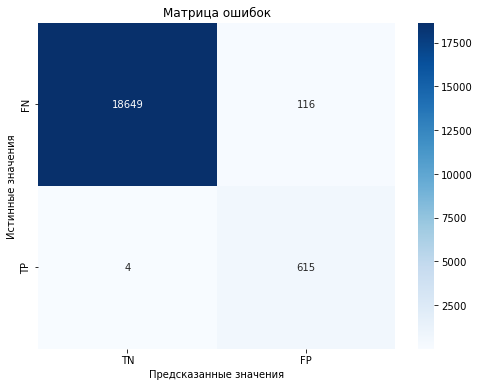

In [49]:
# Генерируем матрицу ошибок
conf_matrix = confusion_matrix(y_test, test_pred_model_lr_resampled)
print("Матрица ошибок:\n", conf_matrix)

# Визуализируем матрицу ошибок на сбалансированных данных
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['TN', 'FP'], yticklabels=['FN', 'TP'])
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок')
plt.show()

In [50]:
# Print the classification report for the model

print(classification_report_imbalanced(y_test, test_pred_model_lr_resampled))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.99      1.00      0.99      0.99     18765
          1       0.84      0.99      0.99      0.91      0.99      0.99       619

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384




<b>Как сбалансированность классов повлияла на работу модели?</b> <br>
<b>Опирайтесь на метрики точности и матрицу ошибок при своем ответе.</b>


**Ответ:** Сбалансированность классов значительно повлияла на работу модели, т.к. точность модели на несбалансированных данных равна 0.958, тем временем уже на сбалансированных данных равна 0.994, что на 0.036 больше. Также сравнивая матрицу ошибок для двух моделей, можно сделать вывод, что количество случаев, когда модель правильно предсказала, что займ будет одобрен (то есть, реальный статус займа - "одобрен", и модель также предсказала "одобрен" у несбалансированной модели равно 18660, а у сбалансированной модели равно 18649; количество случаев, когда модель неправильно предсказала, что займ будет одобрен, хотя на самом деле он не был одобрен (то есть, реальный статус займа - "не одобрен", а модель предсказала "одобрен") у несбалансированной модели равно 105, а у сбалансированной модели равно 116; количество случаев, когда модель неправильно предсказала, что займ не будет одобрен, хотя на самом деле он был одобрен (то есть, реальный статус займа - "одобрен", а модель предсказала "не одобрен") у несбалансированной модели равно 48, а у сбалансированной модели равно 4; количество случаев, когда модель правильно предсказала, что займ не будет одобрен (то есть, реальный статус займа - "не одобрен", и модель также предсказала "не одобрен") у несбалансированной модели равно 571, а у сбалансированной модели равно 615;
И также на классификационном отчете видно, что у сбалансированной модели по всем показателям avg / total равны 0.99, чем не может похвастаться несбалансированная модель.

 # Построение модели опорных векторов для предсказания 'loan_status'

### Построение модели

In [55]:
from sklearn import svm
model_CV = svm.SVC(kernel='poly', degree=3)
model_CV.fit(X_resampled, y_resampled)

SVC(kernel='poly')

### Предсказания на тестовой выборке

In [58]:
# Сделайте предсказания на тестовых данных

test_pred_model_CV = model_CV.predict(X_test)
test_pred_model_CV

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Оценка модели

In [60]:
# выведите balanced_accuracy_score
balanced_accuracy_score(y_test, test_pred_model_CV)

0.9936781215845847

Матрица ошибок:
 [[18649   116]
 [    4   615]]


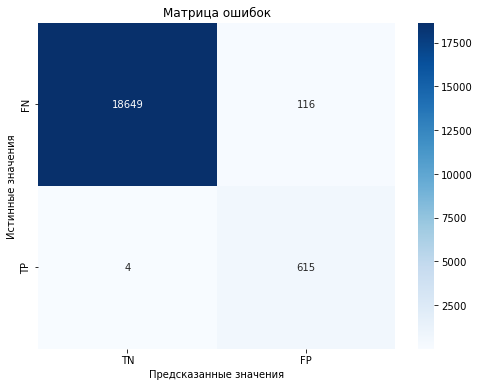

In [61]:
# Сгенерируйте confusion_matrix для модели
conf_matrix_model_CV = confusion_matrix(y_test, test_pred_model_CV)
print("Матрица ошибок:\n", conf_matrix_model_CV)

# Визуализируем матрицу ошибок на сбалансированных данных
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_model_CV, annot=True, fmt='d', cmap='Blues', xticklabels=['TN', 'FP'], yticklabels=['FN', 'TP'])
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок')
plt.show()

In [62]:
# Выведите classification_report для модели
print(classification_report_imbalanced(y_test, test_pred_model_CV))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.99      1.00      0.99      0.99     18765
          1       0.84      0.99      0.99      0.91      0.99      0.99       619

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



# Построение дерева решений для предсказания 'loan_status'

### Построение модели

In [65]:
from sklearn.tree import DecisionTreeClassifier

# постройте базовую модель с дефолтными параметрами и примерьте тренировочные данные

model_DTC = DecisionTreeClassifier()

# Обучение модели на тренировочных данных
model_DTC.fit(X_resampled, y_resampled)

DecisionTreeClassifier()

### Предсказания на тестовой выборке

In [67]:
# Сделайте предсказания на тестовых данных

test_pred_model_DTC = model_DTC.predict(X_test)
test_pred_model_DTC

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [68]:
# оцените точность модели (balanced_accuracy_score)

balanced_accuracy_score(y_test, test_pred_model_DTC)

0.9492782725892522

### Визуализируйте дерево решений

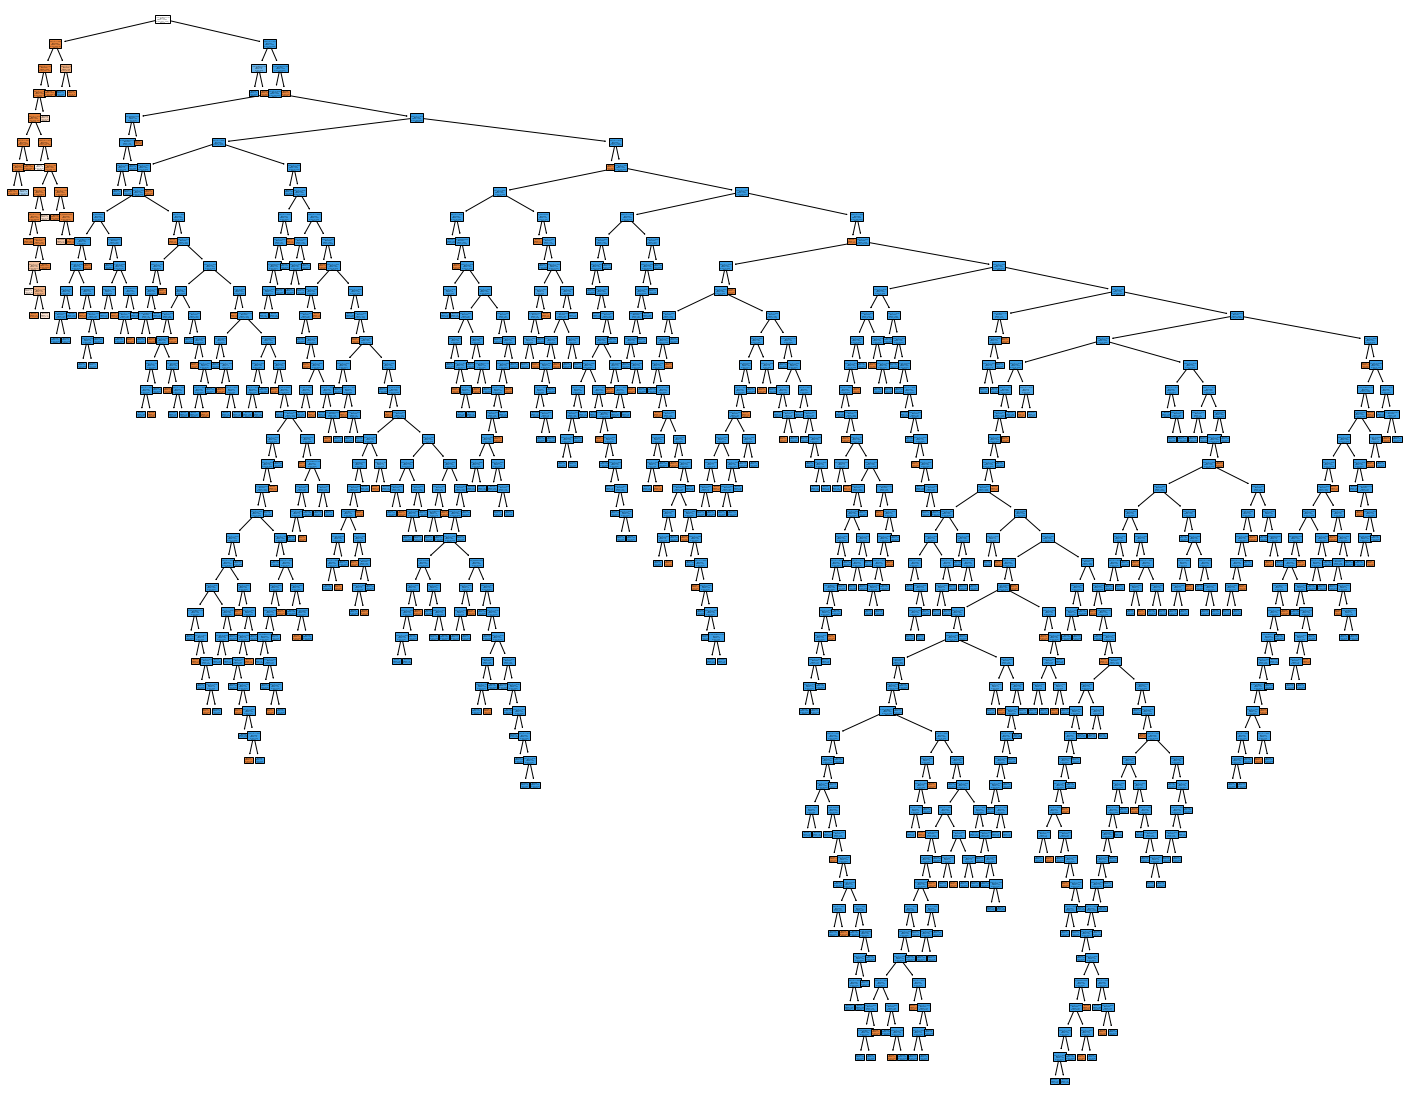

In [70]:
from sklearn import tree

feature_names = df.columns.values.tolist()
feature_names.remove('loan_status')

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_DTC, 
                   feature_names=feature_names,  
                   class_names=['0', '1'],
                   filled=True)

In [71]:
fig.savefig("decision_tree.png")

### Настройка гиперпараметров

Воспользуйтесь алгоритмом GridSearchCV для автоматического подбора гиперпараметров. Можете поэкспериментировать с диапазонами и критериями. После подбора лучших параметров вернитесь к пункту "Построение модели" и укажите новые параметры сборки. Сделайте предсказания, оцените модель и визуализируйте дерево решений. 

In [75]:
model_DTC_grid = DecisionTreeClassifier()

In [76]:
from sklearn.model_selection import GridSearchCV

grid_param = {
 'criterion': ['gini', 'entropy'],
 'splitter' : ['best', 'random'],
 'max_depth': [3,5,10,None],
 'max_features': [1,3,5,7],
 'min_samples_leaf': [1,2,3],
 'min_samples_split': [1,2,3]
 }

grid_search = GridSearchCV(estimator=model_DTC_grid,param_grid=grid_param,cv=5,n_jobs =-1)

grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'max_features': [1, 3, 5, 7],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'splitter': ['best', 'random']})

In [77]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}


In [78]:
best_model_DTC = grid_search.best_estimator_
test_pred_model_DTC_grid = best_model_DTC.predict(X_test)

balanced_accuracy_score(y_test, test_pred_model_DTC_grid)

0.945239500376005

In [79]:
print(grid_search.best_score_)

0.9957171569300522


 best_score_ по другому же параметру находит лучшее значение? не по точности, там вроде в модели можно указать по какому параметру, чтоб искал лучшее значение

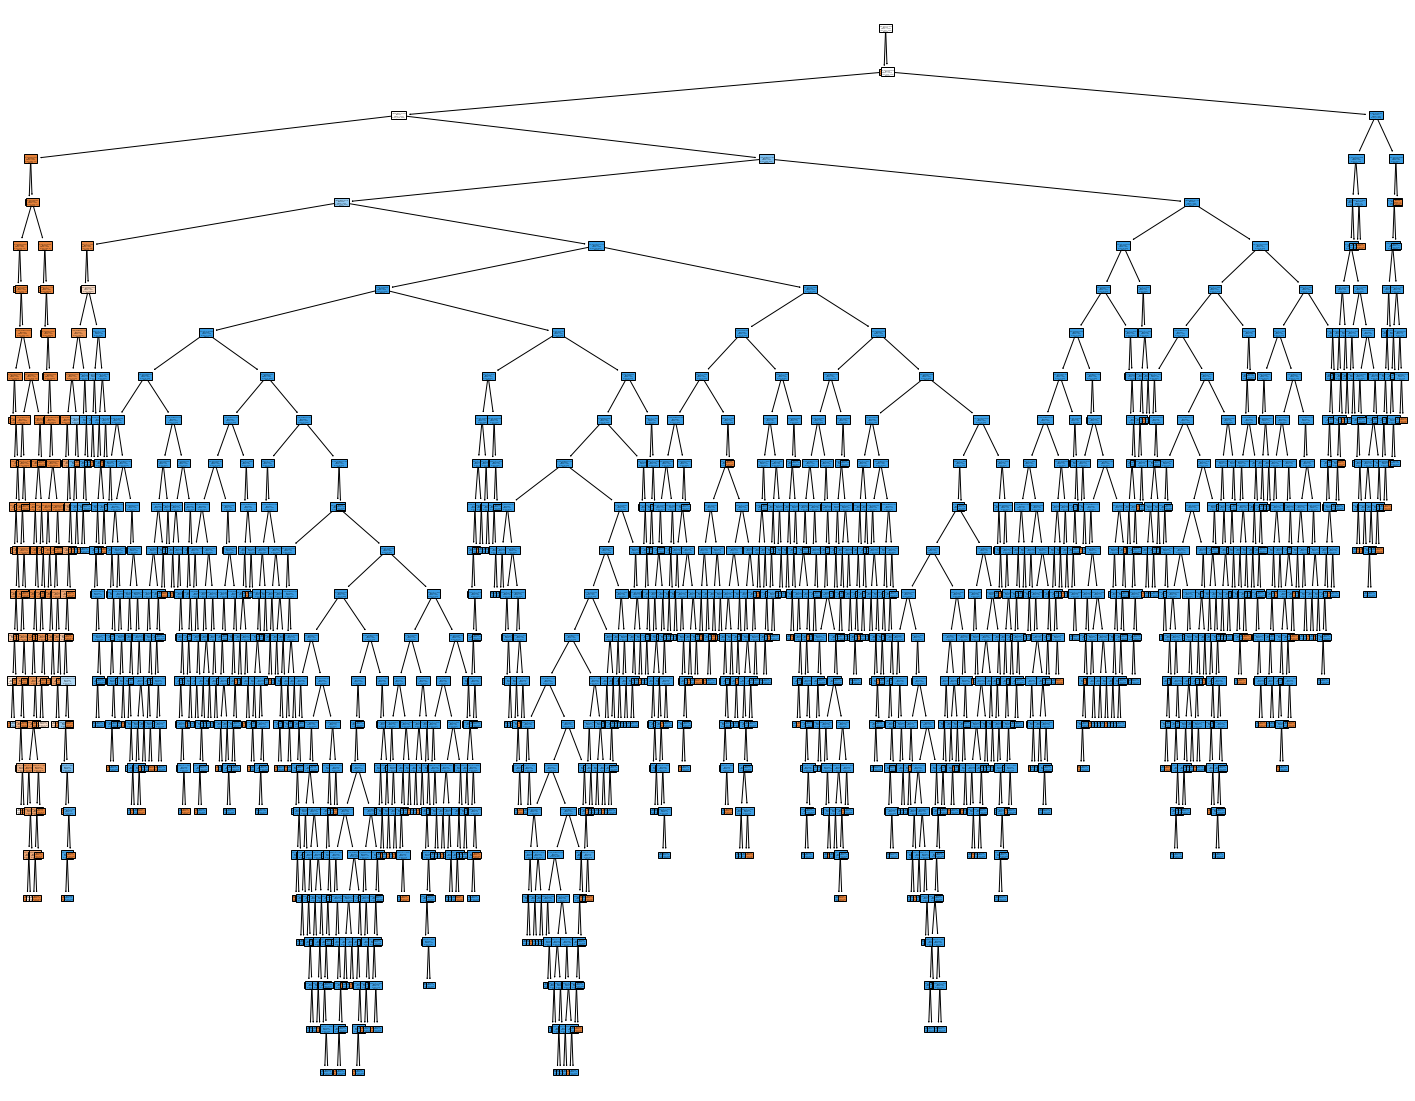

In [81]:
fig_grid = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_model_DTC , 
                   feature_names=feature_names,  
                   class_names=['0', '1'],
                   filled=True)

In [82]:
fig_grid.savefig("decision_tree_grid_search.png")